# 03: Transformer Architecture - Building Blocks

Welcome to the transformer building blocks notebook! In the previous notebook, we learned about **attention** and **multi-head attention** - the core innovation that makes transformers work.

But attention alone isn't enough. A complete transformer needs several other components working together.

## What You'll Learn

In this notebook, we'll build the remaining pieces:

1. **Positional Encoding** - How transformers understand word order
2. **Feed-Forward Networks** - Processing each position independently
3. **Layer Normalization** - Keeping values stable during training
4. **Residual Connections** - Helping information flow through deep networks
5. **Complete Transformer Block** - Assembling everything together

## Why These Components?

After the last notebook, you understand how attention lets words "look at" each other. But there are still problems:

- **Problem 1**: Attention has no sense of position! "Cat chases dog" vs "Dog chases cat" look identical.
- **Problem 2**: Attention just mixes information. We need actual computation/transformation.
- **Problem 3**: As networks get deep, values can explode or vanish.
- **Problem 4**: Deep networks struggle to learn without shortcuts for gradients.

Each component solves one of these problems!

## The Big Picture

A complete transformer block looks like this:

```
Input
  ↓
  + Positional Encoding
  ↓
┌─────────────────────────┐
│ Multi-Head Attention    │ ← From last notebook!
└─────────────────────────┘
  ↓
  + Residual Connection
  ↓
  Layer Normalization
  ↓
┌─────────────────────────┐
│ Feed-Forward Network    │ ← New!
└─────────────────────────┘
  ↓
  + Residual Connection
  ↓
  Layer Normalization
  ↓
Output
```

By the end, you'll understand and implement every part of this diagram!

Let's dive in!

# Setup

In [1]:
import sys
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Add src to path
sys.path.append(os.path.abspath('../src'))
from utils import set_style, print_tensor_info

set_style()
np.random.seed(42)
torch.manual_seed(42)

print("✓ Setup complete!")

✓ Setup complete!


# Part 1: Positional Encoding

## The Problem: Attention is Position-Blind

Remember how attention works? Each word creates Q, K, V and computes attention scores based on similarity.

**But there's a critical issue:**

```
"The cat sat on the mat"
"The mat sat on the cat"
```

To the attention mechanism, these sentences are **identical**! Why?

Because attention only looks at the **content** of words, not their **position**.

### Why RNNs Didn't Have This Problem

RNNs processed words **sequentially**:
```
h1 = RNN(word1)
h2 = RNN(word2, h1)  ← Knows word2 comes after word1
h3 = RNN(word3, h2)  ← Knows word3 comes after word2
```

The position was **implicit** in the processing order.

### Transformers Process Everything in Parallel

```
All words processed simultaneously!
word1 → embedding1 ─┐
word2 → embedding2 ─┤
word3 → embedding3 ─┼→ Attention (parallel)
word4 → embedding4 ─┤
word5 → embedding5 ─┘
```

**Speed is great, but we lost position information!**

## The Solution: Add Position Information

The idea is simple: **Add positional information directly to the embeddings.**

```
Original:  embedding = word_embedding
           ↓
New:       embedding = word_embedding + positional_encoding
```

Now each embedding contains **both**:
- What the word is (word_embedding)
- Where it appears (positional_encoding)

## How to Encode Position?

### Naive Idea #1: Use Position Index

```python
pos_encoding[0] = [0, 0, 0, ...]  # Position 0
pos_encoding[1] = [1, 1, 1, ...]  # Position 1
pos_encoding[2] = [2, 2, 2, ...]  # Position 2
```

**Problem**: Values grow unbounded! Position 1000 would have huge values.

### Naive Idea #2: Normalize Between 0 and 1

```python
pos_encoding[i] = [i/length, i/length, ...]
```

**Problem**: Same position gets different encodings for different sentence lengths!
- Position 1 in a 5-word sentence: 0.2
- Position 1 in a 10-word sentence: 0.1

### The Actual Solution: Sinusoidal Encoding

The transformer paper uses **sine and cosine functions** of different frequencies:

```
PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
```

Where:
- `pos` = position in sequence (0, 1, 2, ...)
- `i` = dimension index (0, 1, 2, ..., d_model-1)
- `d_model` = embedding dimension (e.g., 512)

**Translation**: 
- Even dimensions (0, 2, 4, ...) use sine
- Odd dimensions (1, 3, 5, ...) use cosine
- Different dimensions use different frequencies

## Why Sine and Cosine?

This clever choice has several benefits:

### 1. Bounded Values
Sin and cos always stay between -1 and 1, regardless of position.

### 2. Unique for Each Position
Each position gets a unique pattern across all dimensions.

### 3. Relative Position Information
The model can learn to attend based on relative distances!
```
sin(a + b) = sin(a)cos(b) + cos(a)sin(b)
```
This means PE(pos+k) can be computed as a linear function of PE(pos).

### 4. Works for Any Length
Can handle sequences longer than those seen during training.

## Let's Visualize This!

In [2]:
def get_positional_encoding(seq_len, d_model):
    """
    Generate sinusoidal positional encodings.
    
    Args:
        seq_len: Length of the sequence
        d_model: Dimension of embeddings
    
    Returns:
        Positional encoding matrix of shape (seq_len, d_model)
    """
    # Create position indices [0, 1, 2, ..., seq_len-1]
    position = np.arange(seq_len)[:, np.newaxis]  # Shape: (seq_len, 1)
    
    # Create dimension indices [0, 1, 2, ..., d_model-1]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    
    # Initialize positional encoding matrix
    pe = np.zeros((seq_len, d_model))
    
    # Apply sine to even indices
    pe[:, 0::2] = np.sin(position * div_term)
    
    # Apply cosine to odd indices
    pe[:, 1::2] = np.cos(position * div_term)
    
    return pe

# Generate positional encodings
seq_len = 50
d_model = 128

pos_encoding = get_positional_encoding(seq_len, d_model)

print(f"Positional Encoding Shape: {pos_encoding.shape}")
print(f"Values range from {pos_encoding.min():.3f} to {pos_encoding.max():.3f}")
print(f"\nFirst position encoding (first 10 dims):")
print(pos_encoding[0, :10])

Positional Encoding Shape: (50, 128)
Values range from -1.000 to 1.000

First position encoding (first 10 dims):
[0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


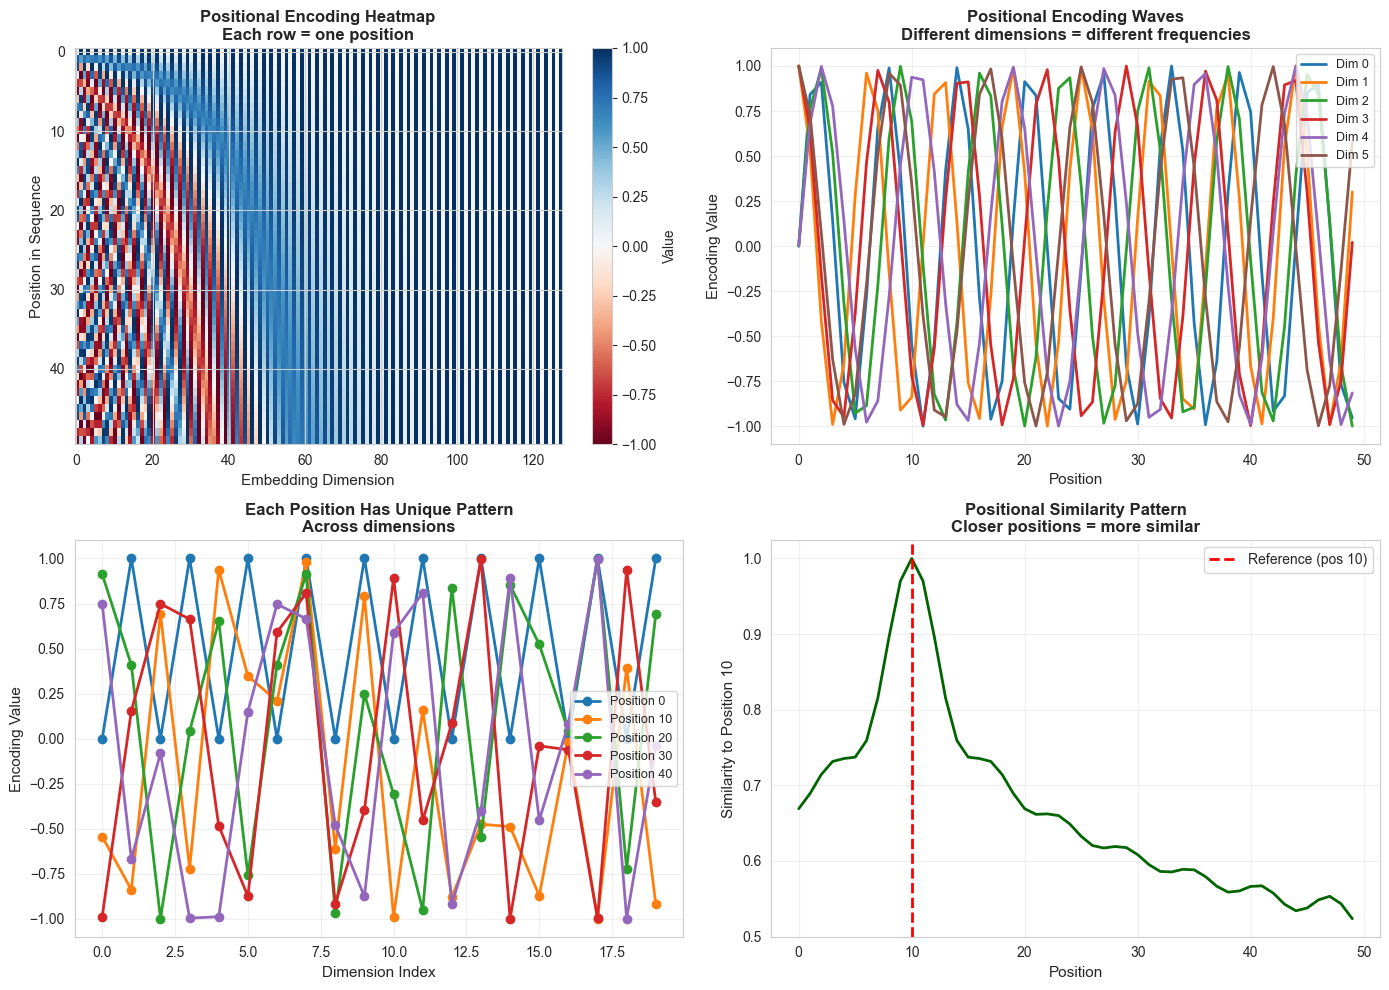


📊 What the plots show:
  Top-left: Each position gets a unique pattern (different row colors)
  Top-right: Different dimensions oscillate at different frequencies
  Bottom-left: Each position has a distinct signature across dimensions
  Bottom-right: Nearby positions are more similar than distant ones


In [3]:
# Visualize positional encodings
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Heatmap of all positional encodings
ax = axes[0, 0]
im = ax.imshow(pos_encoding, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
ax.set_xlabel('Embedding Dimension', fontsize=11)
ax.set_ylabel('Position in Sequence', fontsize=11)
ax.set_title('Positional Encoding Heatmap\nEach row = one position', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax, label='Value')

# Plot 2: First few dimensions over positions
ax = axes[0, 1]
for dim in [0, 1, 2, 3, 4, 5]:
    ax.plot(pos_encoding[:, dim], label=f'Dim {dim}', linewidth=2)
ax.set_xlabel('Position', fontsize=11)
ax.set_ylabel('Encoding Value', fontsize=11)
ax.set_title('Positional Encoding Waves\nDifferent dimensions = different frequencies', 
             fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 3: Compare specific positions
ax = axes[1, 0]
positions_to_show = [0, 10, 20, 30, 40]
x = np.arange(20)  # Show first 20 dimensions
for pos in positions_to_show:
    ax.plot(x, pos_encoding[pos, :20], marker='o', label=f'Position {pos}', linewidth=2)
ax.set_xlabel('Dimension Index', fontsize=11)
ax.set_ylabel('Encoding Value', fontsize=11)
ax.set_title('Each Position Has Unique Pattern\nAcross dimensions', 
             fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 4: Similarity between positions
ax = axes[1, 1]
# Compute cosine similarity between position 10 and all others
reference_pos = 10
similarities = []
for i in range(seq_len):
    # Cosine similarity
    sim = np.dot(pos_encoding[reference_pos], pos_encoding[i]) / \
          (np.linalg.norm(pos_encoding[reference_pos]) * np.linalg.norm(pos_encoding[i]))
    similarities.append(sim)

ax.plot(similarities, linewidth=2, color='darkgreen')
ax.axvline(x=reference_pos, color='red', linestyle='--', linewidth=2, label=f'Reference (pos {reference_pos})')
ax.set_xlabel('Position', fontsize=11)
ax.set_ylabel('Similarity to Position 10', fontsize=11)
ax.set_title('Positional Similarity Pattern\nCloser positions = more similar', 
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 What the plots show:")
print("  Top-left: Each position gets a unique pattern (different row colors)")
print("  Top-right: Different dimensions oscillate at different frequencies")
print("  Bottom-left: Each position has a distinct signature across dimensions")
print("  Bottom-right: Nearby positions are more similar than distant ones")

## How to Use Positional Encoding

It's incredibly simple - just **add** it to your embeddings:

```python
# Before
embeddings = word_embeddings  # Shape: (seq_len, d_model)

# After
pos_enc = get_positional_encoding(seq_len, d_model)
embeddings = word_embeddings + pos_enc  # Element-wise addition
```

That's it! Now the model knows both **what** each word is and **where** it appears.

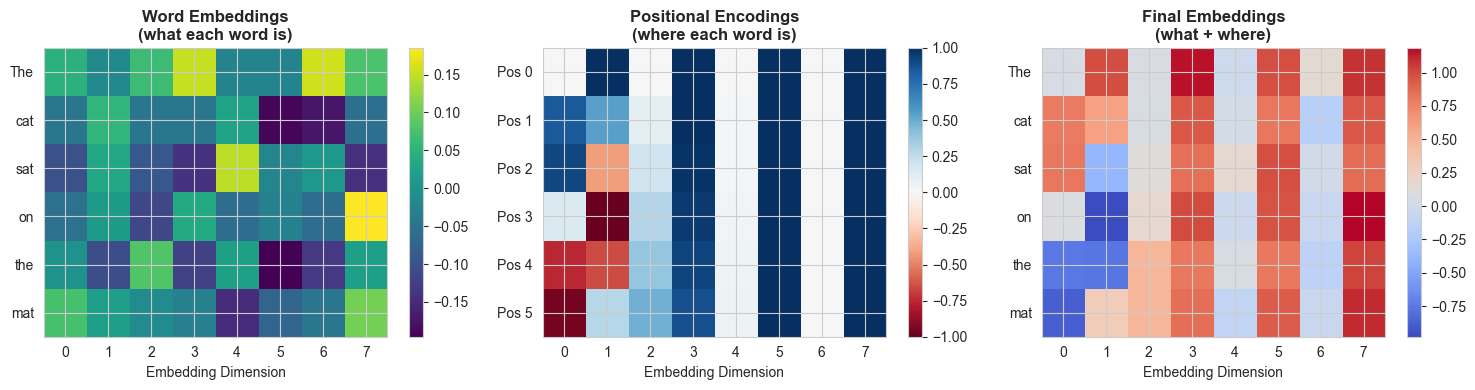

✓ Positional information added to embeddings!
  Now the model knows: 'cat' is the 2nd word, 'mat' is the 6th word, etc.


In [4]:
# Example: Adding positional encoding to embeddings
sentence = ["The", "cat", "sat", "on", "the", "mat"]
seq_len = len(sentence)
d_model = 8  # Small for visualization

# Simulate word embeddings (random for demo)
np.random.seed(42)
word_embeddings = np.random.randn(seq_len, d_model) * 0.1

# Get positional encodings
pos_enc = get_positional_encoding(seq_len, d_model)

# Add them together
final_embeddings = word_embeddings + pos_enc

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Word embeddings
im1 = axes[0].imshow(word_embeddings, aspect='auto', cmap='viridis')
axes[0].set_yticks(range(seq_len))
axes[0].set_yticklabels(sentence)
axes[0].set_xlabel('Embedding Dimension')
axes[0].set_title('Word Embeddings\n(what each word is)', fontweight='bold')
plt.colorbar(im1, ax=axes[0])

# Positional encodings
im2 = axes[1].imshow(pos_enc, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
axes[1].set_yticks(range(seq_len))
axes[1].set_yticklabels([f'Pos {i}' for i in range(seq_len)])
axes[1].set_xlabel('Embedding Dimension')
axes[1].set_title('Positional Encodings\n(where each word is)', fontweight='bold')
plt.colorbar(im2, ax=axes[1])

# Final embeddings
im3 = axes[2].imshow(final_embeddings, aspect='auto', cmap='coolwarm')
axes[2].set_yticks(range(seq_len))
axes[2].set_yticklabels(sentence)
axes[2].set_xlabel('Embedding Dimension')
axes[2].set_title('Final Embeddings\n(what + where)', fontweight='bold')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

print("✓ Positional information added to embeddings!")
print("  Now the model knows: 'cat' is the 2nd word, 'mat' is the 6th word, etc.")

## PyTorch Implementation

In [5]:
class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding layer."""
    
    def __init__(self, d_model, max_len=5000):
        """
        Args:
            d_model: Dimension of embeddings
            max_len: Maximum sequence length (pre-compute up to this)
        """
        super().__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register as buffer (not a parameter, but part of state)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        Args:
            x: Input embeddings of shape (batch_size, seq_len, d_model)
        
        Returns:
            Embeddings with positional encoding added
        """
        seq_len = x.size(1)
        return x + self.pe[:seq_len, :]

# Test it
d_model = 64
batch_size = 2
seq_len = 10

pos_encoding = PositionalEncoding(d_model)
x = torch.randn(batch_size, seq_len, d_model)
output = pos_encoding(x)

print(f"Input shape:  {x.shape}")
print(f"Output shape: {output.shape}")
print(f"✓ Positional encoding added!")

Input shape:  torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])
✓ Positional encoding added!


## Key Takeaways: Positional Encoding

✅ **Why**: Attention is position-blind; we need to tell the model word order  
✅ **How**: Add sinusoidal patterns to embeddings  
✅ **Benefits**:  
   - Bounded values (-1 to 1)
   - Unique pattern for each position
   - Works for any sequence length
   - Model can learn relative positions

✅ **Usage**: Simply add to embeddings before feeding to transformer

---

# Part 2: Feed-Forward Networks

## The Problem: Attention Only Mixes Information

Let's think about what attention does:

```
Attention takes: [word1, word2, word3]
                      ↓
                 Computes: word1 looks at word2, word3
                          word2 looks at word1, word3
                          word3 looks at word1, word2
                      ↓
Produces:  [mixture1, mixture2, mixture3]
```

Attention is essentially **weighted averaging** - it mixes information from different positions.

**But that's all it does!** There's no actual **computation** or **transformation**.

### Analogy: Reading vs Thinking

- **Attention** = Reading and gathering relevant information
- **Feed-Forward** = Actually thinking about what you read

## The Solution: Feed-Forward Networks (FFN)

After attention gathers information, we need to **process** it. That's where the feed-forward network comes in.

## What is a Feed-Forward Network?

It's a simple two-layer neural network applied to **each position independently**:

```
FFN(x) = ReLU(x @ W1 + b1) @ W2 + b2
```

Or in more detail:
```
Input:  [d_model]           (e.g., 512 dimensions)
   ↓
Linear1: [d_model → d_ff]   (expand to e.g., 2048)
   ↓
ReLU:    max(0, x)          (non-linearity)
   ↓
Linear2: [d_ff → d_model]   (compress back to 512)
   ↓
Output: [d_model]
```

### Key Properties

1. **Position-wise**: Applied to each position **independently**
   - Same network for position 0, 1, 2, etc.
   - No mixing between positions (that's attention's job)

2. **Expands then contracts**: 
   - d_model → d_ff (usually 4× larger, e.g., 512 → 2048)
   - d_ff → d_model (back to original size)

3. **Adds non-linearity**: ReLU allows learning complex patterns

## Why This Design?

### The Expansion Trick

Why expand to a larger dimension and then compress back?

```
Think of it like this:
  512 dims → 2048 dims: "Spread out" the information
              ↓
          Apply ReLU: Some neurons fire, others don't
              ↓
  2048 dims → 512 dims: "Compress" back to useful representation
```

This **bottleneck architecture** forces the network to learn useful features:
- Expansion: More capacity to detect patterns
- ReLU: Selectivity (keep some info, discard others)
- Compression: Keep only what's important

### Why ReLU?

```python
ReLU(x) = max(0, x)
```

- Positive values pass through unchanged
- Negative values become zero
- Simple but powerful non-linearity
- Allows the model to learn complex, non-linear patterns

## Let's Implement It!

In [6]:
def feed_forward_numpy(x, W1, b1, W2, b2):
    """
    Position-wise feed-forward network.
    
    Args:
        x: Input of shape (seq_len, d_model)
        W1: First weight matrix (d_model, d_ff)
        b1: First bias (d_ff,)
        W2: Second weight matrix (d_ff, d_model)
        b2: Second bias (d_model,)
    
    Returns:
        Output of shape (seq_len, d_model)
    """
    # First linear layer + ReLU
    hidden = np.maximum(0, x @ W1 + b1)  # ReLU(x @ W1 + b1)
    
    # Second linear layer
    output = hidden @ W2 + b2
    
    return output

# Test it
seq_len = 6
d_model = 8
d_ff = 32  # Usually 4x d_model

# Create random input (simulating output from attention)
np.random.seed(42)
x = np.random.randn(seq_len, d_model)

# Initialize weights (small random values)
W1 = np.random.randn(d_model, d_ff) * 0.01
b1 = np.zeros(d_ff)
W2 = np.random.randn(d_ff, d_model) * 0.01
b2 = np.zeros(d_model)

# Apply FFN
output = feed_forward_numpy(x, W1, b1, W2, b2)

print(f"Input shape:  {x.shape}  → {seq_len} positions, each {d_model} dims")
print(f"Hidden shape: ({seq_len}, {d_ff})  → Expanded to {d_ff} dims")
print(f"Output shape: {output.shape}  → Back to {d_model} dims")
print(f"\n✓ Feed-forward network applied to each position!")

Input shape:  (6, 8)  → 6 positions, each 8 dims
Hidden shape: (6, 32)  → Expanded to 32 dims
Output shape: (6, 8)  → Back to 8 dims

✓ Feed-forward network applied to each position!


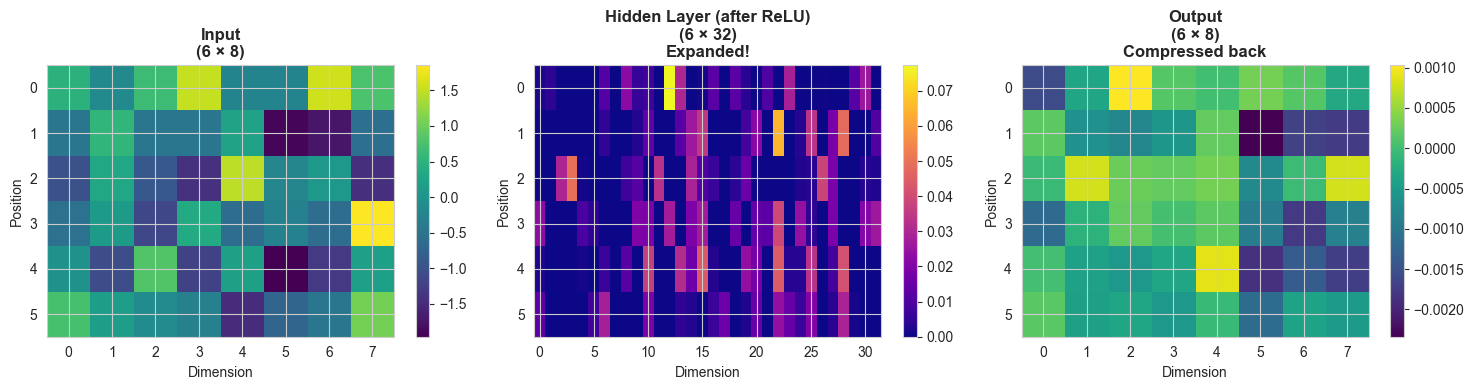

Notice: Each position is processed independently!
The transformation is the same for all positions, but applied separately.


In [7]:
# Visualize what FFN does
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Input
im1 = axes[0].imshow(x, aspect='auto', cmap='viridis')
axes[0].set_xlabel('Dimension')
axes[0].set_ylabel('Position')
axes[0].set_title(f'Input\n({seq_len} × {d_model})', fontweight='bold')
plt.colorbar(im1, ax=axes[0])

# Hidden layer (after first linear + ReLU)
hidden = np.maximum(0, x @ W1 + b1)
im2 = axes[1].imshow(hidden, aspect='auto', cmap='plasma')
axes[1].set_xlabel('Dimension')
axes[1].set_ylabel('Position')
axes[1].set_title(f'Hidden Layer (after ReLU)\n({seq_len} × {d_ff})\nExpanded!', fontweight='bold')
plt.colorbar(im2, ax=axes[1])

# Output
im3 = axes[2].imshow(output, aspect='auto', cmap='viridis')
axes[2].set_xlabel('Dimension')
axes[2].set_ylabel('Position')
axes[2].set_title(f'Output\n({seq_len} × {d_model})\nCompressed back', fontweight='bold')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

print("Notice: Each position is processed independently!")
print("The transformation is the same for all positions, but applied separately.")

## PyTorch Implementation

In [8]:
class FeedForward(nn.Module):
    """Position-wise feed-forward network."""
    
    def __init__(self, d_model, d_ff, dropout=0.1):
        """
        Args:
            d_model: Embedding dimension
            d_ff: Hidden layer dimension (usually 4 × d_model)
            dropout: Dropout probability
        """
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """
        Args:
            x: Input of shape (batch_size, seq_len, d_model)
        
        Returns:
            Output of shape (batch_size, seq_len, d_model)
        """
        # x @ W1 + b1
        x = self.linear1(x)
        
        # ReLU
        x = torch.relu(x)
        
        # Dropout (for regularization)
        x = self.dropout(x)
        
        # @ W2 + b2
        x = self.linear2(x)
        
        return x

# Test it
d_model = 64
d_ff = 256  # 4 × d_model
batch_size = 2
seq_len = 10

ffn = FeedForward(d_model, d_ff)
x = torch.randn(batch_size, seq_len, d_model)
output = ffn(x)

print(f"Input shape:  {x.shape}")
print(f"Output shape: {output.shape}")
print(f"\n✓ Feed-forward network working!")

# Count parameters
num_params = sum(p.numel() for p in ffn.parameters())
print(f"\nNumber of parameters: {num_params:,}")
print(f"  W1: {d_model} × {d_ff} = {d_model * d_ff:,}")
print(f"  b1: {d_ff:,}")
print(f"  W2: {d_ff} × {d_model} = {d_ff * d_model:,}")
print(f"  b2: {d_model:,}")

Input shape:  torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])

✓ Feed-forward network working!

Number of parameters: 33,088
  W1: 64 × 256 = 16,384
  b1: 256
  W2: 256 × 64 = 16,384
  b2: 64


## Key Takeaways: Feed-Forward Networks

✅ **Why**: Attention only mixes; we need actual computation  
✅ **What**: Two-layer network with expansion bottleneck  
✅ **How**: d_model → d_ff (expand) → d_model (compress)  
✅ **Position-wise**: Applied independently to each position  
✅ **ReLU**: Adds non-linearity for learning complex patterns

**The pattern**: Attention mixes → FFN processes

---

# Part 3: Layer Normalization

## The Problem: Unstable Values During Training

As neural networks get deeper, values can become unstable:

```
Layer 1: values between -1 and 1    ✓ Good
Layer 2: values between -10 and 10   ⚠️ Getting bigger
Layer 3: values between -100 and 100  ❌ Too big!
```

Or the opposite:
```
Layer 1: values around 1            ✓ Good
Layer 2: values around 0.1           ⚠️ Getting smaller
Layer 3: values around 0.001         ❌ Too small!
```

### Why This Happens

Each layer involves matrix multiplications:
- If values are > 1, they grow exponentially
- If values are < 1, they shrink exponentially
- Different features can have very different scales

### Why It's a Problem

- **Training instability**: Gradients explode or vanish
- **Slow learning**: Network struggles to learn
- **Poor generalization**: Model doesn't work well on new data

## The Solution: Normalization

**Idea**: After each transformation, normalize the values to have:
- **Mean** = 0
- **Variance** = 1

This keeps values in a stable range throughout the network.

## Layer Normalization vs Batch Normalization

There are different ways to normalize. Let's understand the key difference:

### Input Shape Reminder
```
(batch_size, seq_len, d_model)
     ↓          ↓        ↓
  Examples   Positions Features
```

### Batch Normalization
Normalizes **across the batch** (used in CNNs):
```
For each position and feature:
  Look at all examples in batch
  Normalize across examples
```

**Problem for sequences**: Different sequences have different lengths!

### Layer Normalization (Used in Transformers)
Normalizes **across features** for each example:
```
For each example and position:
  Look at all features
  Normalize across features
```

**Perfect for sequences**: Each position normalized independently!

## The Math

For each position in each example:

```
1. Compute mean: μ = mean(x)
2. Compute variance: σ² = variance(x)
3. Normalize: x_norm = (x - μ) / √(σ² + ε)
4. Scale and shift: output = γ × x_norm + β
```

Where:
- `ε` (epsilon): Small constant (e.g., 1e-6) to prevent division by zero
- `γ` (gamma): Learnable scale parameter
- `β` (beta): Learnable shift parameter

### Why Scale and Shift?

After normalizing, we have mean=0, variance=1. But what if the model **wants** different values?

**Solution**: Let the model learn optimal scale (γ) and shift (β)!

- If γ=√variance and β=mean, we get back the original
- The model learns the best γ and β during training

## Let's Implement It!

In [9]:
def layer_norm_numpy(x, gamma, beta, eps=1e-6):
    """
    Layer normalization.
    
    Args:
        x: Input of shape (seq_len, d_model)
        gamma: Scale parameter of shape (d_model,)
        beta: Shift parameter of shape (d_model,)
        eps: Small constant for numerical stability
    
    Returns:
        Normalized output of shape (seq_len, d_model)
    """
    # Compute mean and variance for each position (across features)
    mean = x.mean(axis=-1, keepdims=True)  # Shape: (seq_len, 1)
    variance = x.var(axis=-1, keepdims=True)  # Shape: (seq_len, 1)
    
    # Normalize
    x_norm = (x - mean) / np.sqrt(variance + eps)
    
    # Scale and shift
    output = gamma * x_norm + beta
    
    return output

# Test it
seq_len = 6
d_model = 8

# Create input with varying scales
np.random.seed(42)
x = np.random.randn(seq_len, d_model) * np.array([0.1, 1, 10, 0.5, 5, 0.01, 2, 20])  # Different scales!

# Initialize gamma and beta
gamma = np.ones(d_model)
beta = np.zeros(d_model)

# Apply layer norm
output = layer_norm_numpy(x, gamma, beta)

print("Input statistics (per position):")
print(f"  Mean: {x.mean(axis=-1)}")
print(f"  Std:  {x.std(axis=-1)}")
print(f"  Range: [{x.min():.2f}, {x.max():.2f}]")

print("\nOutput statistics (per position):")
print(f"  Mean: {output.mean(axis=-1)}  (should be ~0)")
print(f"  Std:  {output.std(axis=-1)}  (should be ~1)")
print(f"  Range: [{output.min():.2f}, {output.max():.2f}]")

print("\n✓ Values normalized to mean=0, variance=1!")

Input statistics (per position):
  Mean: [ 3.06047742 -2.23454211 -3.8259187   2.6963047   1.10769257  1.46994236]
  Std:  [ 5.17865976  3.90053284 10.19584206 13.49634152  3.22068616  7.79913089]
  Range: [-28.49, 37.05]

Output statistics (per position):
  Mean: [-2.77555756e-17 -2.77555756e-17 -2.77555756e-17  0.00000000e+00
 -2.77555756e-17  5.55111512e-17]  (should be ~0)
  Std:  [0.99999998 0.99999997 1.         1.         0.99999995 0.99999999]  (should be ~1)
  Range: [-2.42, 2.55]

✓ Values normalized to mean=0, variance=1!


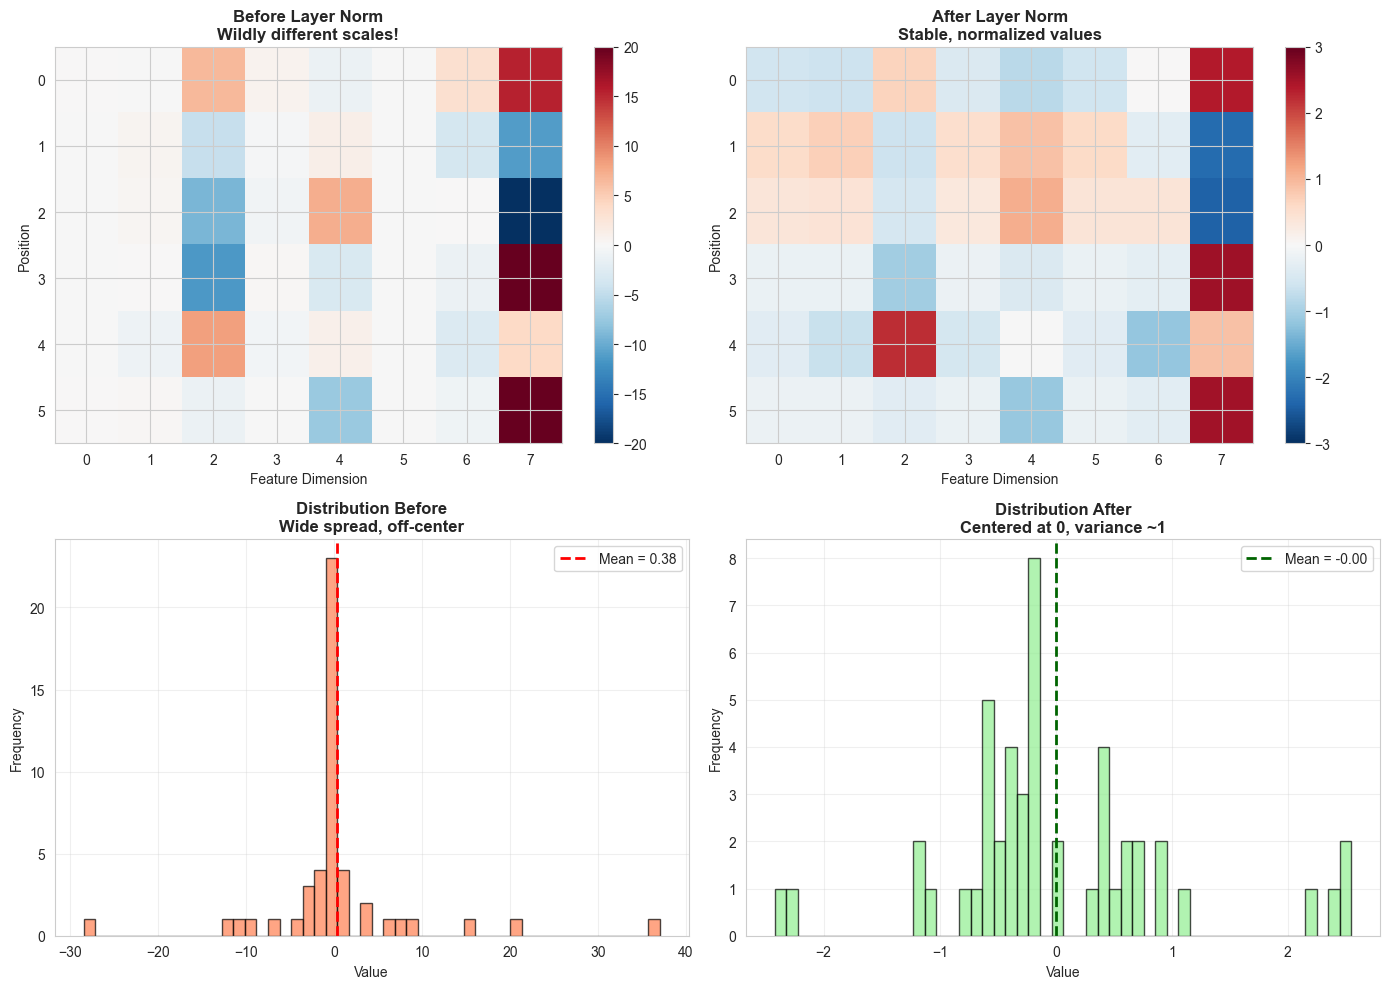

📊 Layer normalization stabilizes the values!


In [10]:
# Visualize the effect of layer normalization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Before normalization - heatmap
ax = axes[0, 0]
im1 = ax.imshow(x, aspect='auto', cmap='RdBu_r', vmin=-20, vmax=20)
ax.set_xlabel('Feature Dimension')
ax.set_ylabel('Position')
ax.set_title('Before Layer Norm\nWildly different scales!', fontweight='bold')
plt.colorbar(im1, ax=ax)

# After normalization - heatmap
ax = axes[0, 1]
im2 = ax.imshow(output, aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
ax.set_xlabel('Feature Dimension')
ax.set_ylabel('Position')
ax.set_title('After Layer Norm\nStable, normalized values', fontweight='bold')
plt.colorbar(im2, ax=ax)

# Distribution before
ax = axes[1, 0]
ax.hist(x.flatten(), bins=50, color='coral', alpha=0.7, edgecolor='black')
ax.axvline(x.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {x.mean():.2f}')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Distribution Before\nWide spread, off-center', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Distribution after
ax = axes[1, 1]
ax.hist(output.flatten(), bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
ax.axvline(output.mean(), color='darkgreen', linestyle='--', linewidth=2, 
           label=f'Mean = {output.mean():.2f}')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Distribution After\nCentered at 0, variance ~1', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Layer normalization stabilizes the values!")

## PyTorch Implementation

In [11]:
# PyTorch has built-in LayerNorm
d_model = 64
batch_size = 2
seq_len = 10

layer_norm = nn.LayerNorm(d_model)

# Create input with different scales
x = torch.randn(batch_size, seq_len, d_model) * torch.linspace(0.1, 10, d_model)

output = layer_norm(x)

print(f"Input shape:  {x.shape}")
print(f"Output shape: {output.shape}")
print(f"\nBefore normalization:")
print(f"  Mean: {x.mean():.4f}")
print(f"  Std:  {x.std():.4f}")
print(f"\nAfter normalization:")
print(f"  Mean: {output.mean():.4f}  (close to 0)")
print(f"  Std:  {output.std():.4f}  (close to 1)")
print(f"\n✓ Layer normalization working!")

Input shape:  torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])

Before normalization:
  Mean: 0.0695
  Std:  6.1234

After normalization:
  Mean: -0.0000  (close to 0)
  Std:  1.0004  (close to 1)

✓ Layer normalization working!


## Key Takeaways: Layer Normalization

✅ **Why**: Stabilizes values as network gets deeper  
✅ **What**: Normalize to mean=0, variance=1 across features  
✅ **How**: (x - μ) / σ, then learnable scale & shift  
✅ **Where**: After attention and after feed-forward  
✅ **Benefit**: Faster training, more stable gradients

---

# Part 4: Residual Connections

## The Problem: Deep Networks Are Hard to Train

As networks get deeper, training becomes harder:

```
Shallow network (2-3 layers):   ✓ Easy to train
Medium network (5-10 layers):   ⚠️ Slower training
Deep network (20+ layers):      ❌ Very hard to train!
```

### Why Deep Networks Struggle

**Problem 1: Vanishing Gradients**
```
During backpropagation:
Output layer:  gradient = 0.5    ✓
Layer 10:      gradient = 0.01   ⚠️ Getting smaller
Layer 5:       gradient = 0.0001 ⚠️ Very small
Layer 1:       gradient ≈ 0      ❌ Can't learn!
```

**Problem 2: Degradation**

Surprisingly, even when we solve vanishing gradients, very deep networks can perform **worse** than shallow ones!

Why? Because it's hard for the network to learn **identity mappings**:
```
If the best thing to do is "just pass the input through unchanged",
the network struggles to learn this!
```

## The Solution: Residual Connections (Skip Connections)

**Brilliant idea**: Instead of learning the full transformation, learn just the **change** (residual).

### Without Residual
```
output = Layer(input)
```
The layer must learn the complete output from scratch.

### With Residual
```
output = input + Layer(input)
```
The layer only learns what to **add** to the input!

## Why This Works

### 1. Easy Identity Mapping
If the best thing is to do nothing:
```
Without residual: Learn Layer(x) = x  (hard!)
With residual:    Learn Layer(x) = 0  (easy! Just make weights zero)
```

### 2. Gradient Highway
Gradients can flow directly through the skip connection:
```
Without residual:
  Output → Layer N → ... → Layer 2 → Layer 1
  (gradient must pass through every layer)

With residual:
  Output → (+) ─────────────────────→ Layer 1
           ↑
        Shortcut! Gradient flows easily
```

### 3. Ensemble Effect
Residual connections create many implicit paths:
```
With 3 blocks, you get 2³ = 8 different paths!
Input → Output
Input → Block1 → Output
Input → Block2 → Output
Input → Block1 → Block2 → Output
...
```

## Residual Connections in Transformers

In transformers, we use residual connections around:
1. Multi-head attention
2. Feed-forward network

```
# Around attention
x = x + MultiHeadAttention(x)
x = LayerNorm(x)

# Around feed-forward
x = x + FeedForward(x)
x = LayerNorm(x)
```

## Let's Implement It!

In [12]:
# Simple demonstration of residual connection
def residual_connection(x, layer_output):
    """
    Add residual connection.
    
    Args:
        x: Original input
        layer_output: Output from the layer
    
    Returns:
        x + layer_output
    """
    return x + layer_output

# Example
seq_len = 6
d_model = 8

np.random.seed(42)
x = np.random.randn(seq_len, d_model)

# Simulate some layer transformation (e.g., from attention or FFN)
layer_output = np.random.randn(seq_len, d_model) * 0.1  # Small changes

# Without residual
output_no_residual = layer_output

# With residual
output_with_residual = residual_connection(x, layer_output)

print("Original input:")
print(x[0, :5])  # First position, first 5 dims

print("\nLayer output (without residual):")
print(output_no_residual[0, :5])
print("  ← Completely different from input!")

print("\nLayer output (with residual):")
print(output_with_residual[0, :5])
print("  ← Similar to input + small changes!")

print("\n✓ Residual connection preserves original information!")

Original input:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337]

Layer output (without residual):
[ 0.03436183 -0.17630402  0.0324084  -0.03850823 -0.0676922 ]
  ← Completely different from input!

Layer output (with residual):
[ 0.53107598 -0.31456832  0.68009694  1.48452163 -0.30184557]
  ← Similar to input + small changes!

✓ Residual connection preserves original information!


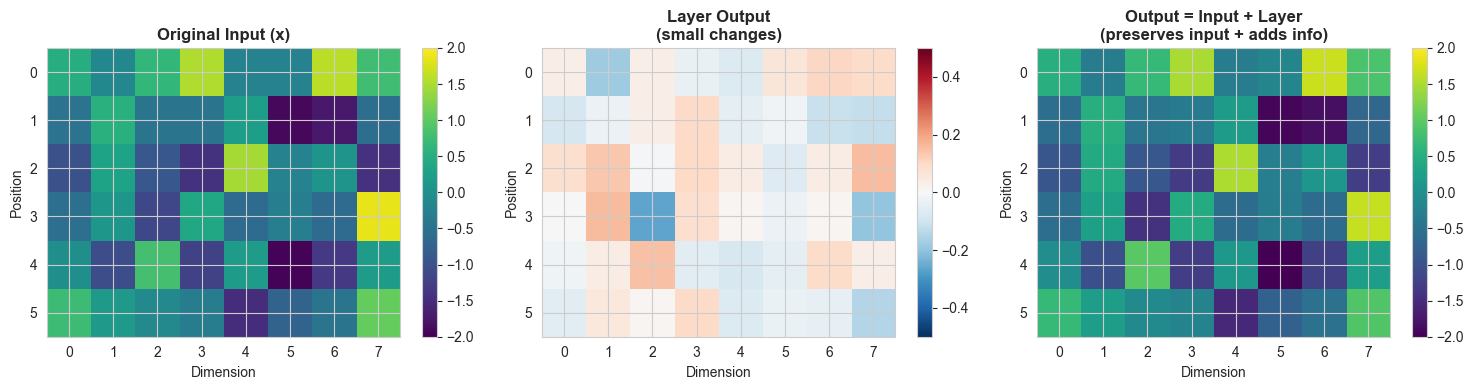

Notice: The output (right) is mostly like the input (left),
        with small modifications from the layer (middle).


In [13]:
# Visualize residual connections
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Original input
im1 = axes[0].imshow(x, aspect='auto', cmap='viridis', vmin=-2, vmax=2)
axes[0].set_xlabel('Dimension')
axes[0].set_ylabel('Position')
axes[0].set_title('Original Input (x)', fontweight='bold')
plt.colorbar(im1, ax=axes[0])

# Layer transformation
im2 = axes[1].imshow(layer_output, aspect='auto', cmap='RdBu_r', vmin=-0.5, vmax=0.5)
axes[1].set_xlabel('Dimension')
axes[1].set_ylabel('Position')
axes[1].set_title('Layer Output\n(small changes)', fontweight='bold')
plt.colorbar(im2, ax=axes[1])

# With residual
im3 = axes[2].imshow(output_with_residual, aspect='auto', cmap='viridis', vmin=-2, vmax=2)
axes[2].set_xlabel('Dimension')
axes[2].set_ylabel('Position')
axes[2].set_title('Output = Input + Layer\n(preserves input + adds info)', fontweight='bold')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

print("Notice: The output (right) is mostly like the input (left),")
print("        with small modifications from the layer (middle).")

## Residual + LayerNorm: The Standard Pattern

In transformers, we combine residuals with layer normalization:

### Post-Norm (Original Transformer Paper)
```python
# After attention
x = LayerNorm(x + MultiHeadAttention(x))

# After feed-forward  
x = LayerNorm(x + FeedForward(x))
```

### Pre-Norm (More Common Now)
```python
# After attention
x = x + MultiHeadAttention(LayerNorm(x))

# After feed-forward
x = x + FeedForward(LayerNorm(x))
```

**Pre-Norm is more stable** and is used in modern models like GPT!

Let's implement both:

In [14]:
class SubLayerConnection(nn.Module):
    """
    Residual connection + layer norm.
    We'll use pre-norm (more stable).
    """
    
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        """
        Apply residual connection to any sublayer with the same size.
        
        Args:
            x: Input of shape (batch_size, seq_len, d_model)
            sublayer: The layer to apply (e.g., attention or FFN)
        
        Returns:
            x + sublayer(norm(x))
        """
        # Pre-norm: normalize first, then apply layer, then add residual
        return x + self.dropout(sublayer(self.norm(x)))

# Test it
d_model = 64
batch_size = 2
seq_len = 10

residual_layer = SubLayerConnection(d_model)

# Create a simple "layer" (just a linear transformation for demo)
dummy_layer = nn.Linear(d_model, d_model)

x = torch.randn(batch_size, seq_len, d_model)
output = residual_layer(x, dummy_layer)

print(f"Input shape:  {x.shape}")
print(f"Output shape: {output.shape}")
print(f"\n✓ Residual connection + LayerNorm working!")

# Verify residual connection
print(f"\nOutput preserves input information:")
print(f"  Correlation between input and output: {torch.corrcoef(torch.stack([x[0,0], output[0,0]]))[0,1]:.3f}")
print(f"  (High correlation = residual connection working)")

Input shape:  torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])

✓ Residual connection + LayerNorm working!

Output preserves input information:
  Correlation between input and output: 0.843
  (High correlation = residual connection working)


## Key Takeaways: Residual Connections

✅ **Why**: Enable training very deep networks  
✅ **What**: Add input to output: `x + Layer(x)`  
✅ **Benefits**:  
   - Easy to learn identity (do nothing)
   - Gradients flow easily through shortcuts
   - Creates ensemble of paths

✅ **In Transformers**: Used around attention and feed-forward  
✅ **With LayerNorm**: Pre-norm is more stable

---

# Part 5: Complete Transformer Block

## Putting It All Together

Now we have all the pieces! Let's assemble a complete transformer block.

### The Architecture

```
Input (with positional encoding)
         ↓
    ┌────────────────────┐
    │   x_norm = LayerNorm(x)         │
    │   attn_out = MultiHeadAttention(x_norm)  │
    │   x = x + attn_out  (residual)  │
    └────────────────────┘
         ↓
    ┌────────────────────┐
    │   x_norm = LayerNorm(x)         │
    │   ffn_out = FeedForward(x_norm) │
    │   x = x + ffn_out   (residual)  │
    └────────────────────┘
         ↓
      Output
```

### Information Flow

1. **Normalize** → Stabilize values
2. **Multi-Head Attention** → Mix information across positions
3. **Residual** → Preserve original information
4. **Normalize** → Stabilize again
5. **Feed-Forward** → Process each position
6. **Residual** → Preserve information again

Each block refines the representation while preserving what was learned before!

## Implementation

In [15]:
# Import MultiHeadAttention from previous notebook
# For this demo, we'll create a simplified version

class SimpleMultiHeadAttention(nn.Module):
    """Simplified multi-head attention for demo."""
    
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Linear projections
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        batch_size = x.size(0)
        
        # Linear projections and reshape for multi-head
        Q = self.W_q(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Apply attention to values
        attn_output = torch.matmul(attn_weights, V)
        
        # Concatenate heads and apply final linear
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(attn_output)
        
        return output

print("✓ Multi-head attention defined!")

✓ Multi-head attention defined!


In [16]:
class TransformerBlock(nn.Module):
    """
    A complete transformer block.
    
    Components:
      1. Multi-head self-attention + residual + layer norm
      2. Feed-forward network + residual + layer norm
    """
    
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        """
        Args:
            d_model: Embedding dimension
            num_heads: Number of attention heads
            d_ff: Feed-forward hidden dimension
            dropout: Dropout probability
        """
        super().__init__()
        
        # Multi-head attention
        self.attention = SimpleMultiHeadAttention(d_model, num_heads, dropout)
        
        # Feed-forward network
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        
        # Layer normalization (2 instances)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        """
        Args:
            x: Input of shape (batch_size, seq_len, d_model)
            mask: Optional attention mask
        
        Returns:
            Output of shape (batch_size, seq_len, d_model)
        """
        # Multi-head attention with residual connection (pre-norm)
        attn_output = self.attention(self.norm1(x), mask)
        x = x + self.dropout(attn_output)
        
        # Feed-forward with residual connection (pre-norm)
        ffn_output = self.feed_forward(self.norm2(x))
        x = x + self.dropout(ffn_output)
        
        return x

print("✓ TransformerBlock defined!")

✓ TransformerBlock defined!


In [17]:
# Test the complete transformer block
d_model = 128
num_heads = 8
d_ff = 512  # 4 × d_model
batch_size = 2
seq_len = 10

# Create transformer block
transformer_block = TransformerBlock(d_model, num_heads, d_ff)

# Create input with positional encoding
x = torch.randn(batch_size, seq_len, d_model)
pos_enc_layer = PositionalEncoding(d_model)
x = pos_enc_layer(x)

# Forward pass
output = transformer_block(x)

print(f"Input shape:  {x.shape}")
print(f"Output shape: {output.shape}")
print(f"\n✓ Complete transformer block working!")

# Count parameters
num_params = sum(p.numel() for p in transformer_block.parameters())
print(f"\nNumber of parameters: {num_params:,}")

# Show that output preserves input (thanks to residual connections)
similarity = torch.nn.functional.cosine_similarity(x.flatten(), output.flatten(), dim=0)
print(f"\nCosine similarity between input and output: {similarity:.3f}")
print("(High similarity shows residual connections preserve information)")

Input shape:  torch.Size([2, 10, 128])
Output shape: torch.Size([2, 10, 128])

✓ Complete transformer block working!

Number of parameters: 198,272

Cosine similarity between input and output: 0.969
(High similarity shows residual connections preserve information)


## Stacking Multiple Blocks

A complete transformer is just **multiple blocks stacked**:

```
Input
  ↓ + Positional Encoding
  ↓
TransformerBlock 1
  ↓
TransformerBlock 2
  ↓
TransformerBlock 3
  ↓
  ...
  ↓
TransformerBlock N
  ↓
Output
```

Each block refines the representation!

In [18]:
class Transformer(nn.Module):
    """Stack of transformer blocks."""
    
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        """
        Args:
            num_layers: Number of transformer blocks
            d_model: Embedding dimension
            num_heads: Number of attention heads
            d_ff: Feed-forward hidden dimension
            dropout: Dropout probability
        """
        super().__init__()
        
        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model)
        
        # Stack of transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        # Final layer norm
        self.norm = nn.LayerNorm(d_model)
    
    def forward(self, x, mask=None):
        """
        Args:
            x: Input of shape (batch_size, seq_len, d_model)
            mask: Optional attention mask
        
        Returns:
            Output of shape (batch_size, seq_len, d_model)
        """
        # Add positional encoding
        x = self.pos_encoding(x)
        
        # Pass through each transformer block
        for block in self.blocks:
            x = block(x, mask)
        
        # Final normalization
        x = self.norm(x)
        
        return x

# Create a small transformer
num_layers = 6  # Like BERT-base
d_model = 128
num_heads = 8
d_ff = 512

transformer = Transformer(num_layers, d_model, num_heads, d_ff)

# Test it
x = torch.randn(batch_size, seq_len, d_model)
output = transformer(x)

print(f"Input shape:  {x.shape}")
print(f"Output shape: {output.shape}")
print(f"\n✓ Complete transformer with {num_layers} layers working!")

# Count parameters
num_params = sum(p.numel() for p in transformer.parameters())
print(f"\nTotal parameters: {num_params:,}")
print(f"Parameters per block: {num_params // num_layers:,}")

Input shape:  torch.Size([2, 10, 128])
Output shape: torch.Size([2, 10, 128])

✓ Complete transformer with 6 layers working!

Total parameters: 1,189,888
Parameters per block: 198,314


## Visualizing the Flow

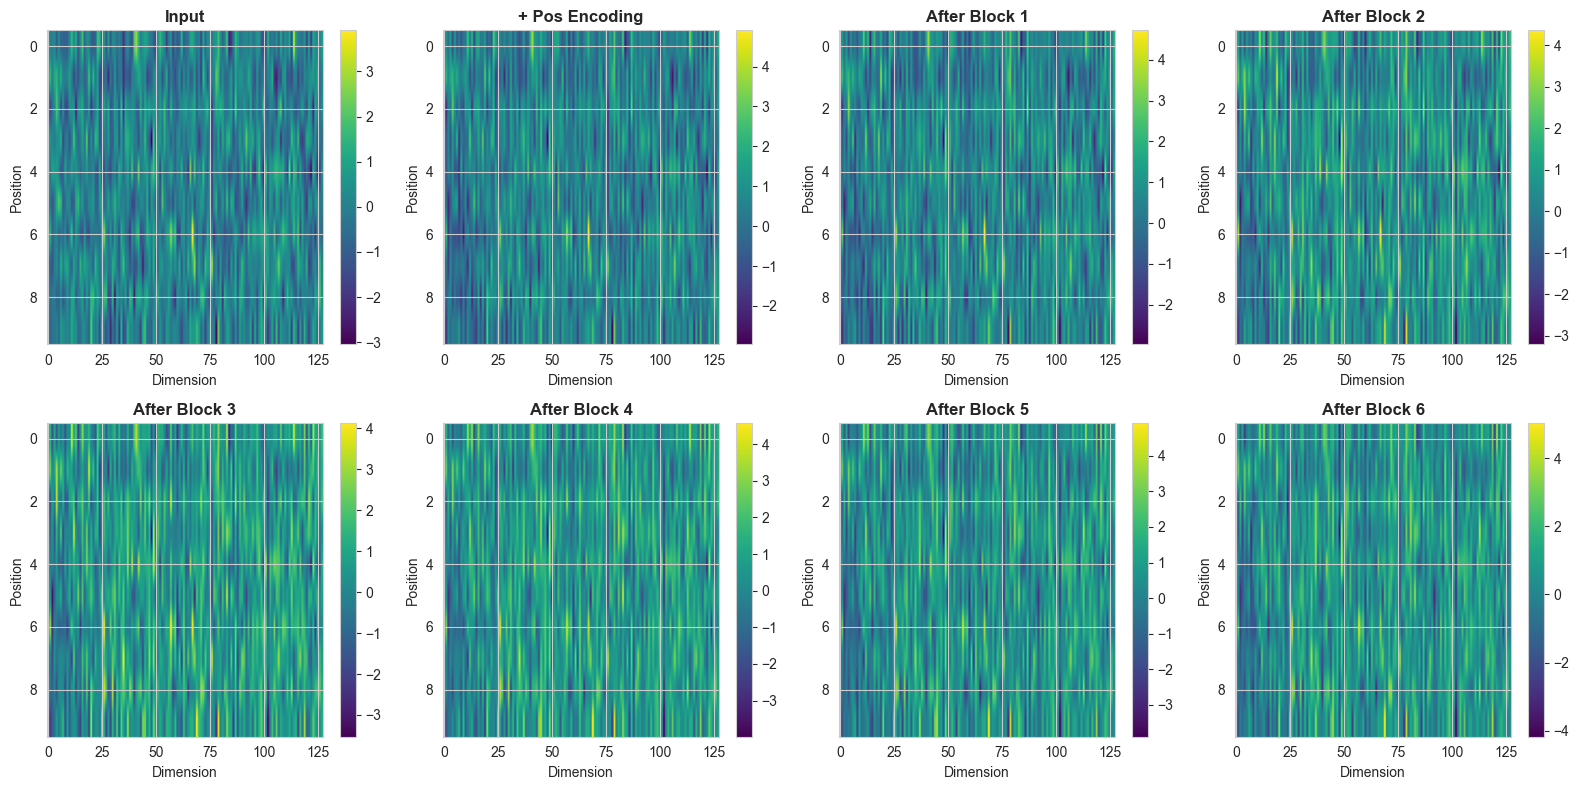


📊 Notice how representations evolve through the layers!
   Each block refines the representation.


In [19]:
# Track how representations change through layers
def forward_with_intermediate(model, x):
    """Forward pass that saves intermediate outputs."""
    outputs = [x]
    
    x = model.pos_encoding(x)
    outputs.append(x)
    
    for i, block in enumerate(model.blocks):
        x = block(x)
        outputs.append(x)
    
    x = model.norm(x)
    outputs.append(x)
    
    return outputs

# Get intermediate outputs
x_input = torch.randn(1, seq_len, d_model)  # Batch size 1 for visualization
intermediate_outputs = forward_with_intermediate(transformer, x_input)

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, output in enumerate(intermediate_outputs[:8]):
    data = output[0].detach().numpy()  # Remove batch dimension
    
    im = axes[i].imshow(data, aspect='auto', cmap='viridis')
    axes[i].set_xlabel('Dimension')
    axes[i].set_ylabel('Position')
    
    if i == 0:
        axes[i].set_title('Input', fontweight='bold')
    elif i == 1:
        axes[i].set_title('+ Pos Encoding', fontweight='bold')
    elif i == len(intermediate_outputs) - 1:
        axes[i].set_title('Final Output', fontweight='bold')
    else:
        axes[i].set_title(f'After Block {i-1}', fontweight='bold')
    
    plt.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

print("\n📊 Notice how representations evolve through the layers!")
print("   Each block refines the representation.")

## Comparison with Original Paper

Our implementation follows the **"Attention Is All You Need"** paper!

### Architecture Summary

| Component | Our Implementation | Original Paper |
|-----------|-------------------|----------------|
| **Positional Encoding** | ✓ Sinusoidal | ✓ Sinusoidal |
| **Multi-Head Attention** | ✓ 8 heads (configurable) | ✓ 8 heads |
| **Feed-Forward** | ✓ d_ff = 4 × d_model | ✓ d_ff = 4 × d_model |
| **Layer Norm** | ✓ Pre-norm | Post-norm* |
| **Residual Connections** | ✓ Around attn & FFN | ✓ Around attn & FFN |
| **Number of Layers** | Configurable | 6 (base) |

*We use pre-norm (more stable), while the original paper used post-norm. Modern implementations prefer pre-norm!

### Key Hyperparameters (BERT-base for reference)

```python
d_model = 768      # Embedding dimension
num_heads = 12     # Attention heads
d_ff = 3072        # Feed-forward dimension (4 × d_model)
num_layers = 12    # Transformer blocks
```

This gives ~110 million parameters!

# Exercises

## Exercise 1: Experiment with Positional Encoding

Try different sequence lengths and embedding dimensions:
1. Generate positional encodings for seq_len=100, d_model=64
2. Visualize how the patterns change
3. What happens if you skip positional encoding entirely? (Try it!)

In [20]:
# Your code here


## Exercise 2: Feed-Forward Expansion Factor

The standard is d_ff = 4 × d_model, but what if we change it?
1. Create FFNs with different expansion factors: 2×, 4×, 8×
2. Count parameters for each
3. What's the trade-off?

In [21]:
# Your code here


## Exercise 3: Impact of Residual Connections

1. Create two transformers: one with residuals, one without
2. Pass the same input through both
3. Compare outputs and gradient flow
4. Which one would be easier to train?

In [22]:
# Your code here


## Exercise 4: Scaling Up

Calculate the number of parameters for:
1. GPT-2 Small: 12 layers, d_model=768, 12 heads
2. GPT-2 Medium: 24 layers, d_model=1024, 16 heads
3. GPT-2 Large: 36 layers, d_model=1280, 20 heads

How does parameter count scale with size?

In [23]:
# Your code here


# Summary & Key Takeaways

## What We Built

We've implemented all the core components of a transformer:

### 1. Positional Encoding
- **Problem**: Attention is position-blind
- **Solution**: Sinusoidal encoding added to embeddings
- **Key insight**: Each position gets a unique pattern

### 2. Feed-Forward Networks
- **Problem**: Attention only mixes, doesn't compute
- **Solution**: Two-layer MLP with expansion
- **Key insight**: Position-wise processing after attention

### 3. Layer Normalization
- **Problem**: Values become unstable in deep networks
- **Solution**: Normalize to mean=0, variance=1
- **Key insight**: Stabilizes training

### 4. Residual Connections
- **Problem**: Deep networks hard to train
- **Solution**: Skip connections (x + Layer(x))
- **Key insight**: Gradients flow easily, preserves information

### 5. Complete Transformer Block
```
x → LayerNorm → Attention → (+) → LayerNorm → FFN → (+) → output
    ↑______________________________|           ↑____________|
         Residual Connection                  Residual Connection
```

## The Big Picture

### What Each Component Does

| Component | Purpose | Analogy |
|-----------|---------|----------|
| **Positional Encoding** | Tell position in sequence | Page numbers in a book |
| **Multi-Head Attention** | Mix information across positions | Reading related paragraphs |
| **Feed-Forward** | Process each position | Thinking about what you read |
| **Layer Norm** | Stabilize values | Keeping notes organized |
| **Residual** | Preserve information | Don't forget what you knew |

### Information Flow

```
Word Embeddings
      ↓
+ Positional Info  ← "Where am I?"
      ↓
Attention          ← "What's relevant?"
      ↓
+ Residual         ← "Don't forget the original!"
      ↓
Normalize          ← "Keep values stable"
      ↓
Feed-Forward       ← "Process the information"
      ↓
+ Residual         ← "Don't forget again!"
      ↓
Normalize          ← "Stabilize again"
      ↓
Repeat for N layers...
      ↓
Rich Representations!
```

## Connecting to the Previous Notebook

**Notebook 02** gave us:
- ✅ Scaled dot-product attention
- ✅ Query, Key, Value mechanism
- ✅ Multi-head attention
- ✅ Attention masks

**This notebook** added:
- ✅ Positional encoding
- ✅ Feed-forward networks
- ✅ Layer normalization
- ✅ Residual connections
- ✅ Complete transformer block

**Together**: We have a complete transformer! 🎉

## What's Next?

### Next Notebook: `04_gpt_architecture.ipynb`

Now that we have the complete transformer, we'll learn:
- **Encoder vs Decoder** - Different transformer variants
- **GPT Architecture** - Decoder-only transformers
- **Causal attention** - Preventing looking ahead
- **Language modeling** - Predicting next tokens
- **Text generation** - Making GPT generate text

### The Journey Ahead

```
✓ Completed: Transformer building blocks
    ↓
→ Next: GPT architecture and generation
    ↓
→ Then: Tokenization
    ↓
→ Finally: Training your own language model!
```

## Key Equations Reference

### Positional Encoding
```
PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
```

### Feed-Forward Network
```
FFN(x) = ReLU(x @ W1 + b1) @ W2 + b2
```

### Layer Normalization
```
LayerNorm(x) = γ × (x - μ) / √(σ² + ε) + β
```

### Transformer Block (Pre-Norm)
```
x = x + Attention(LayerNorm(x))
x = x + FFN(LayerNorm(x))
```

## Skills You've Gained

✅ **Understand** why each component is necessary  
✅ **Implement** all transformer building blocks from scratch  
✅ **Explain** how information flows through a transformer  
✅ **Build** a complete multi-layer transformer  
✅ **Ready** to understand GPT and other transformer variants!

---

# Congratulations! 🎉

You've built a complete transformer from scratch!

You now understand the architecture that powers:
- GPT (ChatGPT, GPT-4)
- BERT (search, understanding)
- Claude (you're using it!)
- And countless other modern AI systems

**You're ready for GPT!** 🚀

See you in the next notebook!